In [176]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow, imsave

In [177]:
img_path = 'data/image_1024_aligned_rgb.png'
plan_path = 'data/floor_plan_test.jpg'
partition_path = 'data/partition.jpg'
depth_path = 'data/depth_map.npy'

In [178]:
img = imread(img_path)
plan = imread(plan_path)
partition = imread(partition_path)
depth = np.load(depth_path)

In [179]:
img.shape

(512, 1024, 3)

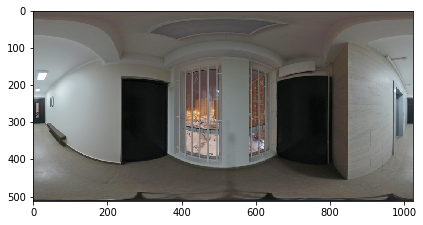

In [180]:
imshow(img)

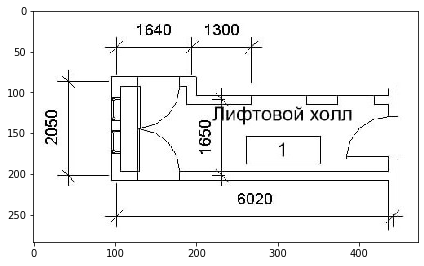

In [181]:
imshow(plan)

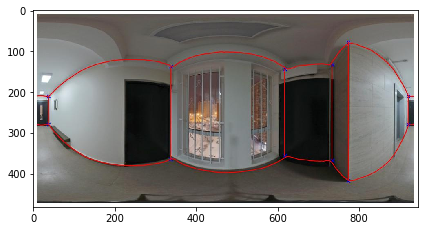

In [182]:
imshow(partition)

In [183]:
horizontal_corners = np.load('data/h_corners.npy')
vertical_corners = np.load('data/v_corners.npy')

In [184]:
print(horizontal_corners.shape)
print(vertical_corners.shape)

(2, 1024)
(12, 2)


In [185]:
first_corner = vertical_corners[0]
first_corner

array([ 30.914364, 222.41164 ], dtype=float32)

In [186]:
from skimage.draw import disk, line, set_color

In [187]:
# rr, cc = disk(first_corner[::-1], 10, shape=img.shape)
# img_with_corn = img.copy()
# img_with_corn[rr, cc] = 1

In [188]:
def plot_on_img(img: np.ndarray, rrs: list, ccs: list, value: int):
    assert(len(rrs) == len(ccs))
    for i in range(len(rrs)):
        img[rrs[i], ccs[i]] = value

In [189]:
def plot_line(img, higher, lower):
    print('h: ', higher)
    print('l: ', lower)
    line_rr, line_cc = line(int(lower[0]), int(lower[1]), int(higher[0]), int(higher[1]))
    # img[line_rr, line_cc] = 11
    set_color(img, (line_rr, line_cc), (255, 0, 0))

def plot_corner(img, corner, r):
    rr, cc = disk(corner, r, shape=img.shape)
    set_color(img, (rr, cc), (0, 0, 255))
    # img[rr, cc] = 1


In [190]:
def get_img_with_v_corners(img, v_corners, r = 10):
    img_with_corners = img.copy()
    for i in range(0, v_corners.shape[0], 2):
        lower = v_corners[i][::-1]
        higher = v_corners[i+1][::-1]

        # plot_line(img_with_corners, higher, lower)
        plot_corner(img_with_corners, higher, r)
        plot_corner(img_with_corners, lower, r)
    return img_with_corners

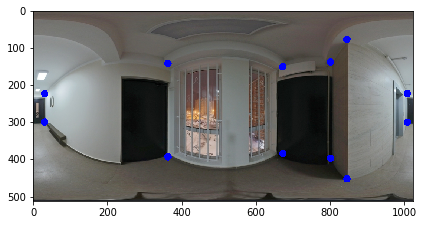

In [191]:
img_with_corn = get_img_with_v_corners(img, vertical_corners)
imshow(img_with_corn)

In [192]:
def plot_h_corners(img, h_corners, r = 2):
    # img_with_corners = img.copy()
    for x in range(h_corners.shape[1]):
        top_y = h_corners[0,x]
        bottom_y = h_corners[1, x]
        plot_corner(img, (top_y, x), r)
        plot_corner(img, (bottom_y, x), r)

In [193]:
img_with_h_corn = img_with_corn.copy()
plot_h_corners(img_with_h_corn, horizontal_corners, 2)

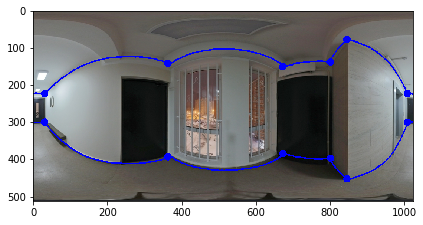

In [194]:
imshow(img_with_h_corn)

In [195]:
def get_point_status(p: tuple, h_corners: np.ndarray) -> str:
    '''
    Является точка частью потолка, стены или пола 
    '''
    y, x = p[0], p[1]

    top_h_corner = h_corners[0, x]
    bottom_h_corner = h_corners[1, x]

    if y <= top_h_corner:
        return 'ceiling'
    elif y >= bottom_h_corner:
        return 'floor'
    else:
        return 'wall'


In [196]:
def get_horizontal_masks(w: int, h: int, h_corners: np.ndarray) -> np.ndarray:
    ceiling_mask = np.zeros((h, w), dtype=bool)
    floor_mask = np.zeros((h, w), dtype=bool)
    wall_mask = np.zeros((h, w), dtype=bool)
    for x in range(h_corners.shape[1]):
        top_y = int(h_corners[0, x])
        ceiling_mask[:top_y, x] = True
        
        bottom_y = int(h_corners[1, x]) 
        floor_mask[bottom_y:, x] = True

        wall_mask[top_y:bottom_y, x] = True
    return ceiling_mask, wall_mask, floor_mask

def get_vertical_masks(w: int, h: int, vertical_corners: np.ndarray) -> np.ndarray:

    split_line_x = [0]

    for i in range(0, vertical_corners.shape[0], 2):
        split_line_x.append(vertical_corners[i, 0])
    
    split_line_x.append(w)

    split_line_x.sort()
    
    segments_number = len(split_line_x) - 1

    segments_masks = []

    for i in range(segments_number):
        mask = np.zeros((h, w), dtype=bool)
        left_x = int(split_line_x[i])
        right_x = int(split_line_x[i + 1])
        print(left_x, right_x)
        mask[:,left_x:right_x] = True
        segments_masks.append(mask)

    return segments_masks

In [197]:
ceil_mask, wall_mask, floor_mask = get_horizontal_masks(img.shape[1], img.shape[0], horizontal_corners)

In [198]:
print(ceil_mask[...,None].shape)
print(img.shape)

(512, 1024, 1)
(512, 1024, 3)


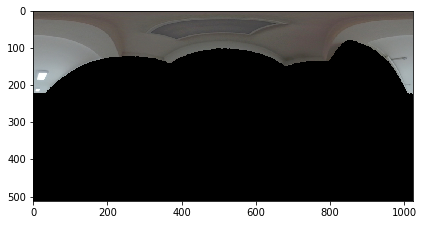

In [199]:
ceil_img = img*ceil_mask[...,None]
imshow(ceil_img)

In [200]:
segments_masks = get_vertical_masks(img.shape[1], img.shape[0], vertical_corners)

0 30
30 363
363 672
672 801
801 845
845 1008
1008 1024


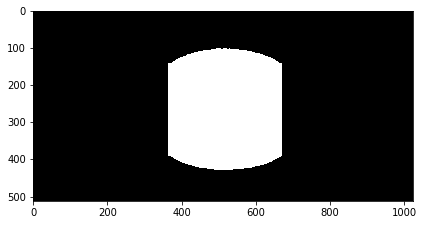

In [201]:
segment_2_mask = segments_masks[2]*wall_mask
imshow(segment_2_mask)

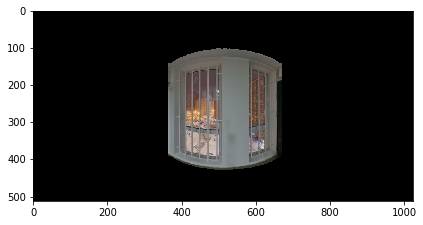

In [202]:
segment_2 = img*segment_2_mask[..., None]
imshow(segment_2)

In [203]:
def get_masked_segment(img: np.ndarray, segments_masks: list, segm_id: int):
    mask = segments_masks[segm_id]*wall_mask
    return img*mask[...,None], mask

In [204]:
depth.shape

(512, 1024)

c:\ProgramData\Python3_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


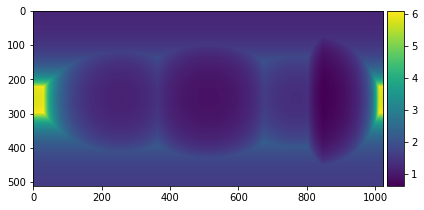

In [205]:
imshow(depth)

In [206]:
ceil_height = 2.5 # высота потолка 2.5 м

In [207]:
def dot_product(v1: np.ndarray, v2: np.ndarray):
    return np.sum(v1*v2) #v1[0]*v2[0] + v1[1]*v2[1] + v1[2]*v2[2]    
# def 

In [208]:
from numpy import linalg as LA

In [209]:
class CoordinatesTransformer:
    ''' класс для преобразования из координат изображения в пространственные

        i = h*thetta
        j = w*phi

       '''

    def __init__(self, img: np.ndarray, depth_map: np.ndarray, ceiling_height: float):
        
        self.img = img
        self.depth_map = depth_map
        self.ceiling_height = ceiling_height

        self.projection_radius = ceiling_height / np.pi

        self.img_h = img.shape[0]
        self.img_w = img.shape[1]

        self.cos_1 = 1#np.cos(np.pi/4 - 1e-1)

    def from_img_to_spherical(self, i, j):
        thetta = i/self.img_h*np.pi #self.projection_radius
        
        phi = j/self.img_w*2*np.pi/self.cos_1 #/np.cos(thetta) #self.projection_radius#/np.cos(thetta) # ????
        return self.depth_map[i,j], phi, thetta

    def from_spherical_to_img(self, phi, thetta):
        i = thetta*self.img_h/np.pi #self.projection_radius
        j = phi*self.img_w/2/np.pi*self.cos_1#*np.cos(thetta) #self.projection_radius
        return int(i), int(j)

    def get_global_point(self, p):
        r, phi, thetta = self.from_img_to_spherical(p[0], p[1])
        global_x = r*np.sin(thetta)*np.cos(phi)
        global_y = r*np.sin(thetta)*np.sin(phi)
        global_z = r*np.cos(thetta)
        return np.array([global_x, global_y, global_z])
    
    def get_img_point(self, global_p):
        x,y,z = global_p[0], global_p[1], global_p[2]
        r = np.sqrt(x**2 + y**2 + z**2)
        thetta = np.arccos(z/(r + 1e-12))
        phi = np.arctan(y/(x + 1e-12))
        i,j = self.from_spherical_to_img(phi, thetta)
        return i,j

    def test(self):
        for i in range(self.img_h):
            for j in range(self.img_w):
                ii, jj = self.get_img_point(self.get_global_point((i,j)))
                if np.abs(ii - i) >= 2 or np.abs(jj - j) >= 2:
                    print(i,j, ii, jj)

        

In [210]:
def normalize(v):
    return v/np.sqrt(np.sum(v**2))

In [211]:
class FlatBasisSystem:
    ''' класс отвечающий за систему координат плоскости. Строит систему по 3м точкам '''

    def __init__(self, c1, c2, c3):

        self.origin = c1

        # базисные вектора
        self.u = normalize(c2 - c1)
        self.v = normalize(c3 - c1)
        # print(np.sqrt(np.sum(self.u**2)))
        self.normal = np.cross(self.u, self.v)
        assert(np.abs((self.u*self.v).sum()) > 1e-7)

    def get_global_point(self, pu, pv):
        return self.origin + self.u*pu + self.v*pv
    
    def get_local_point(self, global_p):
        p = global_p - self.origin
        p = p - dot_product(p, self.normal)*self.normal
        pu = dot_product(p, self.u) # LA.multi_dot(p, self.u)
        pv = dot_product(p, self.v) #(p*self.v).sum() #LA.multi_dot(p, self.v)
        return pu, pv
    
    # @staticmethod
    # def create_from_corners(img:np.ndarray, coord_transformer: CoordinatesTransformer, c1_idx, c2_idx, c3_idx):
        
    #     c1 = 

    #     pass


In [212]:
def get_img_v_corner_i_j(vertical_corners, corn_id):
    return int(vertical_corners[corn_id, 1]), int(vertical_corners[corn_id, 0])

In [213]:
class FlatSegmentObject3D:
    ''' класс содержащий методы для работы с плоскостями в пространстве '''
    


    def __init__(self, img: np.ndarray, segment_mask: np.ndarray, basis: FlatBasisSystem, coord_transformer: CoordinatesTransformer):
        
        self.basis = basis
        self.img = img
        self.segment_mask = segment_mask
        self.coord_transformer = coord_transformer


    def get_local_size(self):
        ''' h = max(i), w = max(j)'''
        h = -1
        w = -1
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if not self.segment_mask[i,j]:
                    continue
                global_p = self.coord_transformer.get_global_point((i, j))
                pi,pj = self.basis.get_local_point(global_p)
                if pi > h:
                    h = pi
                if pj > w:
                    w = pj
        return w, h
    
    def get_value_local(self, local_i, local_j):
        global_p = self.basis.get_global_point(local_i, local_j)
        
        return 



In [214]:
def reconstruct_old(segment, mask, coord_transformer, basis, projection, h, hp, w, wp):
    for i in range(segment.shape[0]):
        for j in range(segment.shape[1]):
            if not mask[i,j]:
                continue
            global_p = coord_transformer.get_global_point((i,j))
            # print(global_p)
            local_p = basis.get_local_point(global_p)
            # print(local_p)
            pi = np.clip(int(hp/h*local_p[0]), 0, hp-1)
            pj = np.clip(int(wp/w*local_p[1]), 0, wp-1)
            # print(pi, pj)
            projection[pi, pj] = img[i, j]

In [215]:
def reconstruct(projection, img, mask, coord_transformer, basis, scale_i, scale_j):
    for i in range(projection.shape[0]):
        for j in range(projection.shape[1]):
            pu = scale_i*i
            pv = scale_j*j

            global_p = basis.get_global_point(pu, pv)

            img_i, img_j = coord_transformer.get_img_point(global_p)

            if mask[img_i, img_j]:
                projection[i,j] = img[img_i, img_j]
    # return projection

In [216]:
def reconstruct_wall_0():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 0))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 1))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 2))

    basis = FlatBasisSystem(c1, c2, c3)

    hp = 512
    wp = int(6.02/2.5*hp) # 6 from json

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    segment, mask = get_masked_segment(img, segments_masks, 1)


    wall = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = wall.get_local_size()

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection
    

In [217]:
projection = reconstruct_wall_0()

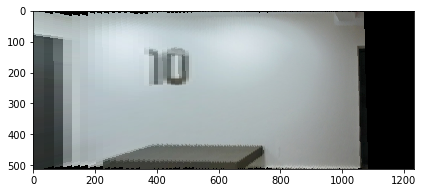

In [ ]:
imshow(projection)

In [ ]:
# imsave("0_proj.jpg", projection)

In [ ]:
pixel_scale = 2.5/512 # м/пиксель

In [ ]:
def reconstruct_floor():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 3)) #3
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 5)) # 5
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 1)) # 1

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = int(2.05/pixel_scale)
    wp = int(6.02/pixel_scale) # 6 from json

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    # segment, mask = get_masked_segment(img, segments_masks, 1)
    mask = floor_mask


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

In [ ]:
floor_proj = reconstruct_floor()

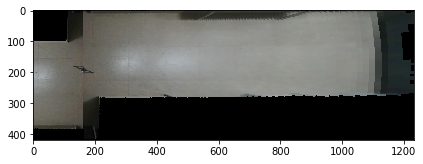

In [ ]:
imshow(floor_proj)

In [ ]:
def reconstruct_ceiling():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 2))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 4))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 0))

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = int(2.05/pixel_scale)
    wp = int(6.02/pixel_scale) # 6 from json

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    # segment, mask = get_masked_segment(img, segments_masks, 1)
    mask = ceil_mask


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

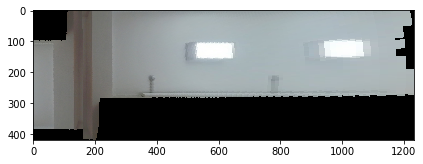

In [ ]:
ceil_proj = reconstruct_ceiling()
imshow(ceil_proj)

In [ ]:
def reconstruct_wall_1():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 2))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 3))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 4))

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = 512
    wp = int(2.05/pixel_scale) 

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    segment, mask = get_masked_segment(img, segments_masks, 2)


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    print(w,h)

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

2.4263470398956657 2.8056468084578836


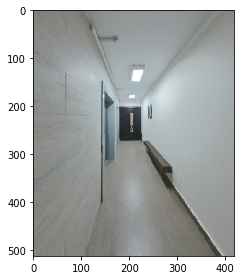

In [ ]:
wall_1_proj = reconstruct_wall_1()
imshow(wall_1_proj)

In [ ]:
def reconstruct_wall_2():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 4))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 5))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 6))

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = 512
    wp = int(1.6/pixel_scale) 

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    segment, mask = get_masked_segment(img, segments_masks, 3)


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    print(w,h)

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

1.1484591875036718 2.814884492861659


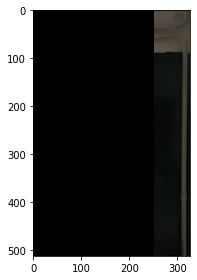

In [ ]:
wall_2_proj = reconstruct_wall_2()
imshow(wall_2_proj)

In [ ]:
def reconstruct_wall_3():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 5))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 6))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 7))

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = 512
    wp = int(0.4/pixel_scale) 

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    segment, mask = get_masked_segment(img, segments_masks, 4)


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    print(w,h)

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

1.1660185556123244 3.025534401462015


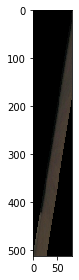

In [ ]:
wall_3_proj = reconstruct_wall_3()
imshow(wall_3_proj)

In [ ]:
def reconstruct_wall_4():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    # coord_transformer.test()
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 6))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 7))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, 8))

    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = FlatBasisSystem(c1, c2, c3)

    hp = 512
    wp = int(4.38/pixel_scale) 

    projection = np.zeros((hp, wp, 3), dtype = 'uint8')
    
    segment, mask = get_masked_segment(img, segments_masks, 5)


    obj = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = obj.get_local_size()

    print(w,h)

    reconstruct(projection, img, mask, coord_transformer, basis, h/hp, w/wp)

    return projection

0.8380877387873323 2.814590303746255


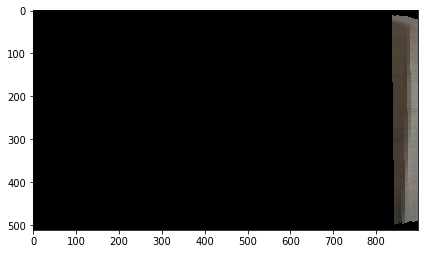

In [ ]:
wall_4_proj = reconstruct_wall_4()
imshow(wall_4_proj)